<a href="https://colab.research.google.com/github/kiitaamuuraa/Asobiba/blob/main/DGL_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに
[A Blitz Introduction to DGL](https://docs.dgl.ai/tutorials/blitz/index.html) を一気にやって、GNNの実装面の基礎固めをする。8/3/2021に開始


# 00. インストール

In [1]:
!nvidia-smi

Wed Aug  4 14:28:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# CUDA のバージョンを見てDGLを落とすこと
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 164.0 MB 233 bytes/s 


# 01. [Node Classification with DGL](https://docs.dgl.ai/tutorials/blitz/1_introduction.html#sphx-glr-tutorials-blitz-1-introduction-py)

始めのチュートリアルなので少し丁寧に記入している

## モジュールのインポート

In [3]:
import dgl
import dgl.data

import torch
import torch.nn as nn
import torch.nn.functional as F

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


## データセットの読み込み

In [4]:
dataset = dgl.data.CoraGraphDataset()

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [68]:
g = dataset[0]
g.to('cuda')

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

### CORA データセットについて
* 論文の参照関係のグラフ
* ノード特徴は1,433次元のBoW（One-Hot表現）
* ノード数は2,708（論文数）
```python 
g.ndata['feat'].shape  # torch.Size([2708, 1433])
```
* リンク数は5,429



### APPENDIX 他にどんなデータセットある???

In [138]:
dir(dgl.data)

['AIFBDataset',
 'AMDataset',
 'AmazonCoBuy',
 'AmazonCoBuyComputerDataset',
 'AmazonCoBuyPhotoDataset',
 'BGSDataset',
 'BitcoinOTC',
 'BitcoinOTCDataset',
 'CitationGraphDataset',
 'CiteseerGraphDataset',
 'Coauthor',
 'CoauthorCSDataset',
 'CoauthorPhysicsDataset',
 'CoraBinary',
 'CoraFull',
 'CoraFullDataset',
 'CoraGraphDataset',
 'DGLBuiltinDataset',
 'DGLDataset',
 'FB15k237Dataset',
 'FB15kDataset',
 'FakeNewsDataset',
 'FraudAmazonDataset',
 'FraudDataset',
 'FraudYelpDataset',
 'GDELT',
 'GDELTDataset',
 'GINDataset',
 'ICEWS18',
 'ICEWS18Dataset',
 'KarateClub',
 'KarateClubDataset',
 'LegacyPPIDataset',
 'LegacyTUDataset',
 'MUTAGDataset',
 'MiniGCDataset',
 'PPIDataset',
 'PubmedGraphDataset',
 'QM7b',
 'QM7bDataset',
 'QM9',
 'QM9Dataset',
 'QM9Edge',
 'QM9EdgeDataset',
 'RedditDataset',
 'SBMMixture',
 'SBMMixtureDataset',
 'SST',
 'SSTDataset',
 'Subset',
 'TUDataset',
 'WN18Dataset',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',


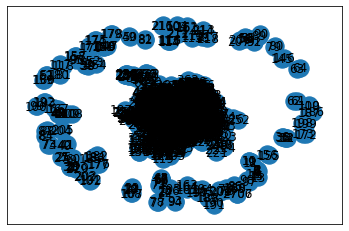

In [74]:
import networkx as nx
g_nx = g.to_networkx()
nx.draw_networkx(g_nx)

In [34]:
print('Node features')
print(g.ndata)
print('Edge features')
print(g.edata)

Node features
{'train_mask': tensor([False, False, False,  ..., False, False, False]), 'val_mask': tensor([False, False,  True,  ..., False, False, False]), 'test_mask': tensor([ True,  True, False,  ..., False, False, False]), 'label': tensor([4, 4, 4,  ..., 4, 3, 3]), 'feat': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0526, 0.0000]])}
Edge features
{}


In [19]:
for k in g.ndata.keys():
    print(f'{k}: type is {type(g.ndata[k])} \n\tshape is {g.ndata[k].shape}')

train_mask: type is <class 'torch.Tensor'> 
	shape is torch.Size([2708])
val_mask: type is <class 'torch.Tensor'> 
	shape is torch.Size([2708])
test_mask: type is <class 'torch.Tensor'> 
	shape is torch.Size([2708])
label: type is <class 'torch.Tensor'> 
	shape is torch.Size([2708])
feat: type is <class 'torch.Tensor'> 
	shape is torch.Size([2708, 1433])


In [22]:
g.ndata['train_mask'].sum(), g.ndata['val_mask'].sum(), g.ndata['test_mask'].sum()

(tensor(140), tensor(500), tensor(1000))

## 二層のGCN作成

In [38]:
from dgl.nn import GraphConv

In [54]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
        

In [71]:
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
model.cuda()

GCN(
  (conv1): GraphConv(in=1433, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=7, normalization=both, activation=None)
)

In [58]:
features = g.ndata['feat']
labels = g.ndata['label']
logits = model(g, features)
logits.shape

torch.Size([2708, 7])

## トレーニング

In [75]:
def train(g, model, EPOCHS=1000):
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
    best_val_acc = 0
    best_tet_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']

    for e in range(EPOCHS):
        logits = model(g, features)
        pred = logits.argmax(1)

        if e == 0:
            print(f'The shape of logits is {logits.shape}.')
            print(f'The pred[:20] is {pred[:20]}.\n')

        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 500 == 0:
            print('In epoch {}/{}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, EPOCHS, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)


In [ ]:
train(g, model, EPOCHS=100000)

65000エポックでもまだloss, val acc, test acc すべて下がる  

```
In epoch 65000, loss: 0.559, val acc: 0.720 (best 0.720), test acc: 0.744 (best 0.740)  
In epoch 65500, loss: 0.555, val acc: 0.720 (best 0.720), test acc: 0.744 (best 0.740)  
In epoch 66000, loss: 0.552, val acc: 0.720 (best 0.720), test acc: 0.744 (best 0.740)  
In epoch 66500, loss: 0.548, val acc: 0.720 (best 0.720), test acc: 0.744 (best 0.740)  
```

# 02. [How Does DGL Represent A Graph?](https://docs.dgl.ai/tutorials/blitz/2_dglgraph.html#sphx-glr-tutorials-blitz-2-dglgraph-py)


In [77]:
import dgl 
import numpy as np
import torch

In [117]:
# ノード数が6でノード0からノード1, 2, 3, 4, 5に向かって接続しているグラフ
# 一つ目のリストが接続元ノード、二つ目のリストが接続先ノード
NUM_NODES = 6
g = dgl.graph(([0, 0, 0, 0, 0, 1, 1, 2, 4], [1, 2, 3, 4, 5, 2, 5, 4, 5]), num_nodes=NUM_NODES)
g

Graph(num_nodes=6, num_edges=9,
      ndata_schemes={}
      edata_schemes={})

全ての基本なので、[```dgl.graph```](https://docs.dgl.ai/generated/dgl.graph.html#dgl.graph) ドキュメントは読んでおいた方がいい

In [124]:
g.ndata['x'] = torch.randn(g.num_nodes(), 3)
g.ndata['y'] = torch.randn(g.num_nodes(), 5, 4)

g.edata['a'] = torch.randn(g.num_edges(), 4)

g

Graph(num_nodes=6, num_edges=9,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'y': Scheme(shape=(5, 4), dtype=torch.float32)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32)})

In [94]:
g.ndata['z'] = torch.randn((NUM_NODES - 2), 5, 4)
# ノードの特徴は、ノード数と一致させる必要がある。

DGLError: ignored

In [113]:
print(g.num_nodes())
print(g.num_edges())
# これはノードゼロから5本外に接続が出ていっていることを表現
print(g.out_degrees())
# これはノード1～5それぞれに向かって接続が入っていっていることを表現 
print(g.in_degrees()) 

6
5
tensor([5, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 1])


In [114]:
sg1 = g.subgraph([0, 1, 3])
sg2 = g.edge_subgraph([0, 1, 3])

In [115]:
sg1

Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

### 無向グラフ
無向グラフを作ると言うよりも、以下のAPIで双方向の有向グラフを作るイメージ  
```python
dgl.add_reverse_edges(ORIGINAL_GRAPH_OBJECT)
```

In [116]:
newg = dgl.add_reverse_edges(g)
newg = dgl.add_reverse_edges(g)
newg.edges()

(tensor([0, 0, 0, 0, 0, 1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 0, 0, 0, 0, 0]))

### 保存と読み出し

In [ ]:
dgl.save_graphs('graph.dgl', g)
dgl.save_graphs('graphs.dgl', [g, sg1, sg2])

# Load graphs
(g,), _ = dgl.load_graphs('graph.dgl')
print(g)
(g, sg1, sg2), _ = dgl.load_graphs('graphs.dgl')
print(g)
print(sg1)
print(sg2)

# 03. [Write your own GNN module](https://docs.dgl.ai/tutorials/blitz/3_message_passing.html#sphx-glr-tutorials-blitz-3-message-passing-py)


In [125]:
import dgl 
import torch
import torch.nn
import torch.nn.functional as F

In [126]:
import dgl.function as fn

実はSAGEConvはあるらしいが、ここでは勉強のために実装するとのこと
```python
# 例
dgl.nn.SAGEConv(100, 20, 'gcn')
```

In [135]:
class SAGEConv(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(SAGEConv, self).__init__()
        self.linear = nn.Linear(in_feat * 2, out_feat)

    def forward(self, g, h):
        # with文はグラフの特徴量を途中で変更しない的な役割
        with g.local_scope():
            g.ndata['h'] = h
            g.update_all(message_func=fn.copy_u('h', 'm'), reduce_func=fn.mean('m', 'h_N'))
            h_N = g.ndata['h_N']
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

```update_all```で近傍の特徴量を集約し、平均する。

In [136]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

上の[二層のGCN作成](https://colab.research.google.com/drive/1OInjZZpi5OyQOeojAimmLT41TYxmaMBj#scrollTo=_GCN_)で定義した```GCN```とほぼ同じなことが分かるので比較すると良い

# 04. [Link Prediction using Graph Neural Networks](https://docs.dgl.ai/tutorials/blitz/4_link_predict.html#sphx-glr-tutorials-blitz-4-link-predict-py)

In [139]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

In [140]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [147]:
u, v = g.edges()
u.shape, v.shape

(torch.Size([10556]), torch.Size([10556]))

In [150]:
print(u[:30])
print(v[:30])

tensor([3, 5, 6, 2, 1, 5, 3, 6, 0, 0, 5, 3, 6, 5, 4, 0, 1, 2, 7, 6, 3, 5, 7, 8,
        6, 2, 4, 1, 0, 3])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5,
        5, 5, 5, 5, 5, 5])


In [154]:
eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_size, train_size

(1055, 9501)

In [179]:
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

assert len(test_pos_u) == len(test_pos_v) and \
        len(train_pos_u) == len(train_pos_v)

In [163]:
adj = sp.coo_matrix((
                    np.ones(len(u)), (u.numpy(), v.numpy())
                     ))

In [166]:
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())

In [167]:
neg_u, neg_v = np.where(adj_neg != 0)

In [169]:
neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[train_size:]], neg_v[neg_eids[train_size:]]

In [170]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [187]:
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

リンク予測ではノードのペアの表現を計算しないといけない

In [188]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [203]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

In [190]:
class MLPPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [200]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
pred = DotPredictor() # MLPPredictorに交換可能

In [201]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [202]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


In epoch 0, loss: 0.6922218799591064
In epoch 5, loss: 0.3516864478588104
In epoch 10, loss: 0.3153718113899231
In epoch 15, loss: 0.33701276779174805
In epoch 20, loss: 0.31960529088974
In epoch 25, loss: 0.30015215277671814
In epoch 30, loss: 0.3010431230068207
In epoch 35, loss: 0.29419785737991333
In epoch 40, loss: 0.2859377861022949
In epoch 45, loss: 0.2812596559524536
In epoch 50, loss: 0.276080459356308
In epoch 55, loss: 0.2695831060409546
In epoch 60, loss: 0.2629373073577881
In epoch 65, loss: 0.25635358691215515
In epoch 70, loss: 0.24944013357162476
In epoch 75, loss: 0.24127860367298126
In epoch 80, loss: 0.23035061359405518
In epoch 85, loss: 0.2156180590391159
In epoch 90, loss: 0.1950709968805313
In epoch 95, loss: 0.17013922333717346
AUC 0.7473300240336023
